In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import time

In [3]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

# MNISTの場合，60000が学習，10000がテスト，と決まっている
# http://yann.lecun.com/exdb/mnist/

X_train, X_test = mnist.data[:60000]/255., mnist.data[60000:]/255.
y_train, y_test = mnist.target[:60000], mnist.target[60000:]


In [4]:
X_train.shape, X_test.shape

((60000, 784), (10000, 784))

In [5]:
from sklearn.linear_model import SGDClassifier

In [6]:
clf = SGDClassifier(loss="log") # Logistic regression

In [7]:
for thin in [100, 50, 10, 5, 4, 3, 2, 1]:
    st = time.time()
    clf.fit(X_train[::thin], y_train[::thin])
    et = time.time() - st
    score = clf.score(X_test[::thin], y_test[::thin])
    print("{0:.2f} sec, size {1}, accuracy {2}".format(et, 
                                                       y_train[::thin].size,
                                                       score))

0.10 sec, size 600, accuracy 0.81
0.14 sec, size 1200, accuracy 0.84
0.60 sec, size 6000, accuracy 0.858
1.20 sec, size 12000, accuracy 0.856
1.49 sec, size 15000, accuracy 0.8692
1.98 sec, size 20000, accuracy 0.8815236952609478
2.98 sec, size 30000, accuracy 0.8652
5.65 sec, size 60000, accuracy 0.907


In [8]:
clf = SGDClassifier(loss="hinge") # linear SVM

In [9]:
for thin in [100, 50, 10, 5, 4, 3, 2, 1]:
    st = time.time()
    clf.fit(X_train[::thin], y_train[::thin])
    et = time.time() - st
    score = clf.score(X_test[::thin], y_test[::thin])
    print("{0:.2f} sec, size {1}, accuracy {2}".format(et, 
                                                       y_train[::thin].size,
                                                       score))

0.04 sec, size 600, accuracy 0.84
0.07 sec, size 1200, accuracy 0.845
0.32 sec, size 6000, accuracy 0.853
0.64 sec, size 12000, accuracy 0.8765
0.79 sec, size 15000, accuracy 0.8628
1.08 sec, size 20000, accuracy 0.8782243551289742
1.68 sec, size 30000, accuracy 0.8766
3.22 sec, size 60000, accuracy 0.8891


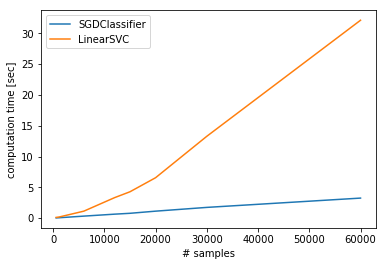

In [10]:
from sklearn.svm import LinearSVC

for clf in [SGDClassifier(loss="hinge"),
            LinearSVC(dual=False)]:
    times = []
    sizes = []
    for thin in [100, 50, 10, 5, 4, 3, 2, 1]:
        st = time.time()
        clf.fit(X_train[::thin], y_train[::thin])
        times.append(time.time() - st)
        sizes.append(y_train[::thin].size)
    plt.plot(sizes, times, label=clf.__class__.__name__)

plt.legend(loc="best")
plt.ylabel("computation time [sec]")
plt.xlabel("# samples")
plt.show()

scikit-learn document: [Logistic regression](http://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

$$
\min_{w,b}
\frac{1}{2} \| w \|_2^2
+ C \sum_{i=1}^N
\log(\exp(-y_i(w^T x_i + b)) + 1)
$$
                                             
scikit-learn document: [SVC](http://scikit-learn.org/stable/modules/svm.html#svc)

$$
\min_{w, b, \{\xi_i\} }
\frac{1}{2} \| w \|_2^2
+ C \sum_{i=1}^N \xi_i
\quad \text{subject to}\quad 
y_i(w^T x_i + b) \ge 1 - \xi_i
$$

In [11]:
C_range_exp = np.arange(-5.0, 15.0)
C_range = 10 ** C_range_exp

scores = []
comp_time = []

clf = SGDClassifier(loss="hinge") # SVM

for C in C_range:
    clf.alpha = X_train.shape[0] / C # n_sample/alpha = C http://scikit-learn.org/stable/modules/svm.html#svc

    st = time.time()
    clf.fit(X_train, y_train)
    et = time.time() - st

    comp_time.append(et)
    score = clf.score(X_test, y_test)
    scores.append(score)
    
    print(C, et, score)

1e-05 6.192193984985352 0.1032
0.0001 5.789118051528931 0.1416
0.001 5.832761764526367 0.1678
0.01 5.695427179336548 0.1741
0.1 6.296325206756592 0.0958
1.0 5.681892156600952 0.0958
10.0 5.685110092163086 0.098
100.0 5.702815055847168 0.2532
1000.0 5.703980922698975 0.1032
10000.0 4.2864830493927 0.7648
100000.0 3.804821014404297 0.8065
1000000.0 3.626236915588379 0.8862
10000000.0 7.793937921524048 0.9067
100000000.0 10.306014060974121 0.9024
1000000000.0 10.661073923110962 0.8738
10000000000.0 10.149407863616943 0.8429
100000000000.0 9.907172918319702 0.8828
1e+12 10.00750994682312 0.8846
1e+13 10.224251747131348 0.8907
1e+14 9.786956071853638 0.8995


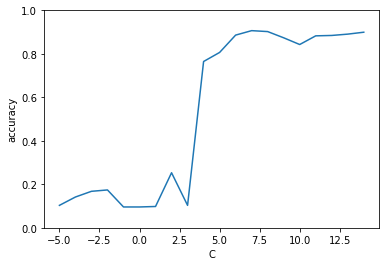

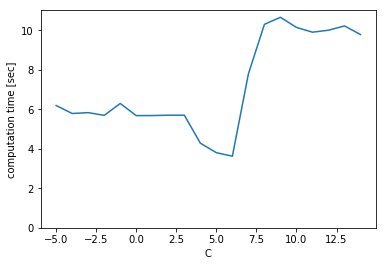

In [12]:
scores = np.array(scores)
comp_time = np.array(comp_time)

plt.plot(C_range_exp, scores)
plt.ylabel("accuracy")
plt.xlabel("C");
plt.ylim(0,1)

plt.show()

plt.plot(C_range_exp, comp_time)
plt.ylim(0,)
plt.ylabel("computation time [sec]")
plt.xlabel("C");

In [13]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


estimators = [('scaler', MinMaxScaler()), 
              ('clf', SGDClassifier(loss="hinge"))]

pipe = Pipeline(estimators)

param = {'clf__alpha': (X_train.shape[0] * 2./3.) / (10**np.arange(-5.0, 10.0)) }

gs = GridSearchCV(pipe, param, n_jobs=-1, verbose=2)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV] clf__alpha=4000000000.0 .........................................
[CV] clf__alpha=4000000000.0 .........................................
[CV] clf__alpha=4000000000.0 .........................................
[CV] clf__alpha=400000000.0 ..........................................
[CV] clf__alpha=400000000.0 ..........................................
[CV] clf__alpha=400000000.0 ..........................................
[CV] clf__alpha=40000000.0 ...........................................
[CV] clf__alpha=40000000.0 ...........................................
[CV] .......................... clf__alpha=4000000000.0, total=  22.3s
[CV] clf__alpha=40000000.0 ...........................................
[CV] .......................... clf__alpha=4000000000.0, total=  22.9s
[CV] clf__alpha=4000000.0 ............................................
[CV] .......................... clf__alpha=4000000000.0, total=  24.1s
[CV] clf__alpha=

[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.7min


[CV] ................................... clf__alpha=4.0, total=  18.7s
[CV] clf__alpha=0.04 .................................................
[CV] .................................. clf__alpha=40.0, total=  23.5s
[CV] clf__alpha=0.04 .................................................
[CV] ................................... clf__alpha=4.0, total=  19.2s
[CV] clf__alpha=0.04 .................................................
[CV] ................................... clf__alpha=0.4, total=  17.9s
[CV] ................................... clf__alpha=4.0, total=  19.3s
[CV] .................................. clf__alpha=40.0, total=  23.1s
[CV] clf__alpha=0.004 ................................................
[CV] ................................... clf__alpha=0.4, total=  18.1s
[CV] clf__alpha=0.004 ................................................
[CV] clf__alpha=0.004 ................................................
[CV] clf__alpha=0.0004 ...............................................
[CV] .

[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  2.4min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(steps=[('scaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('clf', SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__alpha': array([  4.00000e+09,   4.00000e+08,   4.00000e+07,   4.00000e+06,
         4.00000e+05,   4.00000e+04,   4.00000e+03,   4.00000e+02,
         4.00000e+01,   4.00000e+00,   4.00000e-01,   4.00000e-02,
         4.00000e-03,   4.00000e-04,   4.00000e-05])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=2)

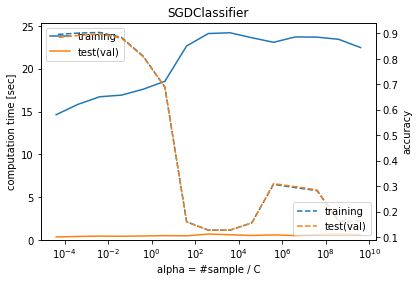

In [14]:
plt.plot(gs.cv_results_['param_clf__alpha'].data, 
         gs.cv_results_['mean_fit_time'], 
         label="training")

plt.plot(gs.cv_results_['param_clf__alpha'].data,
         gs.cv_results_['mean_score_time'], 
         label="test(val)")
plt.ylabel("computation time [sec]")
plt.ylim(0,)
plt.xscale("log")
plt.xlabel("alpha = #sample / C")
plt.legend(loc="upper left");

plt.twinx()

plt.plot(gs.cv_results_['param_clf__alpha'].data, 
         gs.cv_results_['mean_train_score'], 
         linestyle="--",
         label="training")

plt.plot(gs.cv_results_['param_clf__alpha'].data,
         gs.cv_results_['mean_test_score'], 
         linestyle="--",
         label="test(val)")
plt.ylabel("accuracy")
plt.legend(loc="lower right");

plt.title("SGDClassifier")

In [15]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X = data.data
y = data.target

In [16]:
from sklearn.model_selection import ShuffleSplit
ss = ShuffleSplit(n_splits=1, 
                  train_size=0.8, 
                  test_size=0.2, 
                  random_state=0)

train_index, test_index = next(ss.split(X, y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test  = scaler.transform(X_test)

In [18]:
clf = SGDClassifier(loss="hinge") # SVM

In [19]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.93859649122807021

In [20]:
clf = SGDClassifier(loss="log") # logistic regression

In [21]:
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.93859649122807021